In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


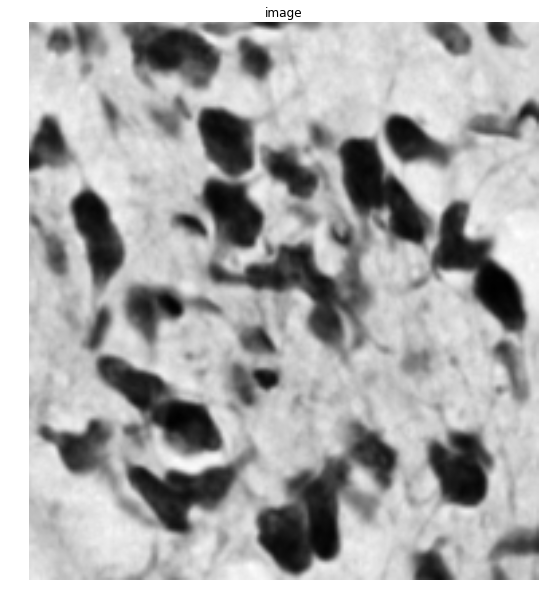

In [2]:
img = imread('/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD589_lossless_aligned_cropped_grayscale/MD589_0134_lossless_aligned_cropped_grayscale.tif')
im = img[7245:7245+208, 2845:2845+190]

plt.figure(figsize=(10,10));
plt.imshow(im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('image');

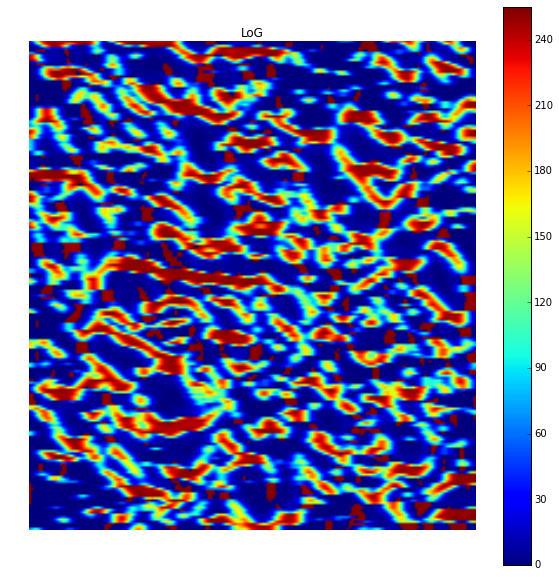

In [3]:
LoG = nd.gaussian_laplace(im, 2)

plt.figure(figsize=(10,10));
plt.imshow(LoG);
plt.axis('off');
plt.title('LoG');
plt.colorbar();

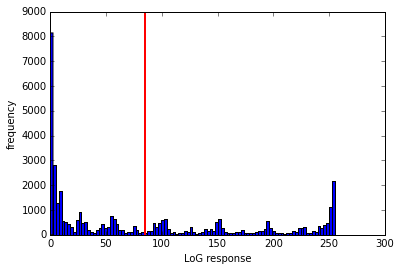

In [4]:
# red line is the threshold

LoG_thres = np.absolute(LoG).mean()

plt.hist(LoG.flat, bins=100);
plt.gca().axvline(x=LoG_thres, c='r', linewidth=2);
plt.xlabel('LoG response');
plt.ylabel('frequency');

In [5]:
s3 = np.sign(LoG - LoG_thres)
s3[s3==0] = -1     # replace zeros with -1

diff_x = np.r_[np.zeros((1,im.shape[1]), np.bool), (np.diff(s3, axis=0) != 0)]
diff_y = np.c_[np.zeros((im.shape[0], 1), np.bool), (np.diff(s3, axis=1) != 0)]
           
zero_crossings3 = np.where(diff_x | diff_y)

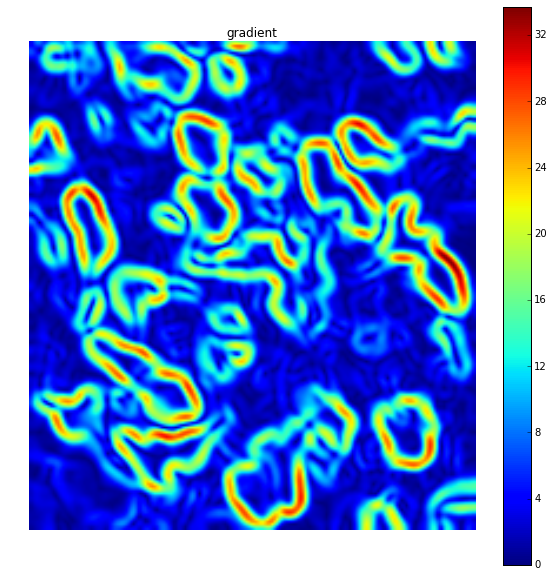

In [6]:
Gy, Gx = np.gradient(nd.gaussian_filter(im.astype(np.float), 2))
# Gy, Gx = np.gradient(im.astype(np.float))
G = np.sqrt(Gx**2+Gy**2)

plt.figure(figsize=(10,10));
plt.imshow(G);
plt.axis('off');
plt.title('gradient');
plt.colorbar();

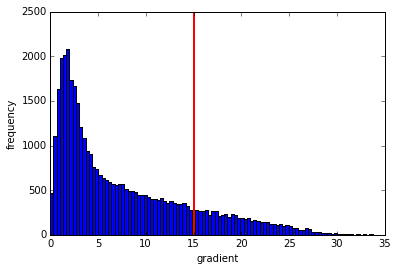

In [7]:
# red line is the threshold

G_thresh = 15

plt.hist(G.flat, bins=100);
plt.gca().axvline(x=G_thresh, c='r', linewidth=2);
plt.xlabel('gradient');
plt.ylabel('frequency');

In [8]:
output = np.zeros_like(im, dtype=np.bool)
output[zero_crossings3] = True

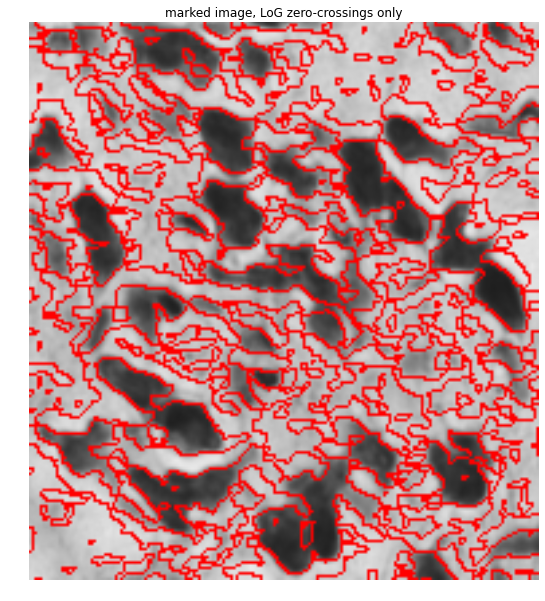

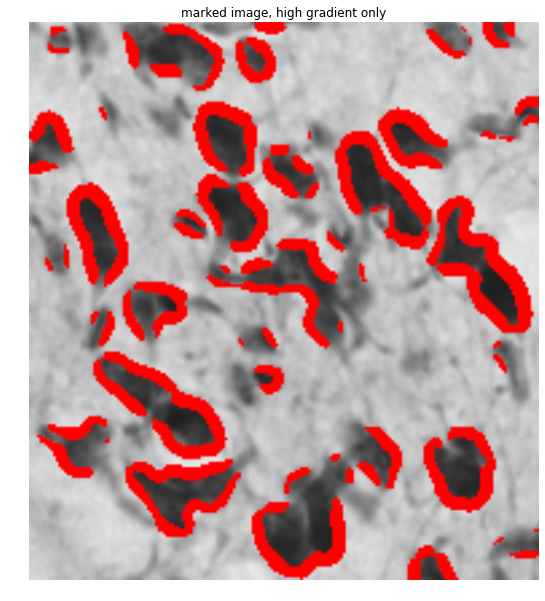

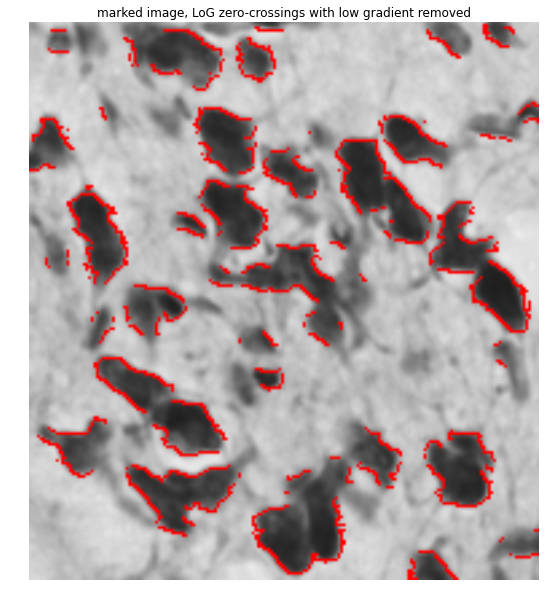

In [9]:
marked_im = gray2rgb(im)
marked_im[output] = (255,0,0)

plt.figure(figsize=(10,10));
plt.imshow(marked_im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('marked image, LoG zero-crossings only');

#################

output3 = G > G_thresh

marked_im3 = gray2rgb(im)
marked_im3[output3] = (255,0,0)

plt.figure(figsize=(10,10));
plt.imshow(marked_im3, cmap=plt.cm.gray);
plt.axis('off');
plt.title('marked image, high gradient only');

#################

output2 = output & (G > G_thresh)

marked_im2 = gray2rgb(im)
marked_im2[output2] = (255,0,0)

plt.figure(figsize=(10,10));
plt.imshow(marked_im2, cmap=plt.cm.gray);
plt.axis('off');
plt.title('marked image, LoG zero-crossings with low gradient removed');